# Testing: SimCorrelator

In [5]:
# imports
import numpy as np
import pandas as pd
import numpy.ma as ma
import importlib
import matplotlib
from astropy.stats import sigma_clipped_stats
from importlib import reload
import time
from astropy.io import fits
import re
import functools

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

#personal
from pipeline.est_pipeline import *
from pipeline.code.file_reader import *
from pipeline.code.corr_plots import *
from pipeline.code.cluster import *

import pipeline.code.Estimator as es
import pipeline.code.Estimator_R as er
import pipeline.code.data_table as d_t
import pipeline.code.graph_code as gc

import pipeline.code.Correlator as Cor
from importlib import reload

import t_const_code as tc

import itertools

In [6]:
# file we're mostly interested in testing
import pipeline.code.SimCorrelator as sCor

In [7]:
# General directories
home_dir = "/home/emcewen/"
data_path = "/home/imaka/data/"
out_dir = "/home/emcewen/test_simul/"
target_path = "home/imaka_wfp/inputs/targets/"

## Sim_inj tests
using the test_sim.py file for multiprocessing estimations

In [8]:
# available variables from files:
dates = ["20180531", "20180601", "20181219", "20181221", "20181222", "20181223", "20210429", "20210430", "20210501", "20210502"]
r0s = ["0.10", "0.15", "0.20", "0.25" ]
vspds = ["001", "003", "006", "012", "018", "024"]
vdirs = ["0", "1", "2", "3"]

In [9]:
bg_test_file=home_dir + "code_dev/bg_sub_inj_test_data.txt"
bg_data=pd.read_csv(bg_test_file, sep='\t')

Text(0.5, 1.0, 'VSPD vs. detected FL SPD, per window')

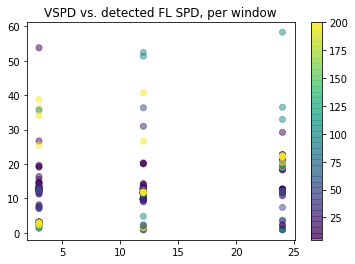

In [10]:
# for FA layers only
df_detect = bg_data[bg_data["class"]=="FL"]
# injected speed vs actual speed
plt.scatter(df_detect['vspd'], df_detect['spd'], c=df_detect['sub_len'], alpha= 0.5)
# different windows in different colors
plt.colorbar()
plt.title("VSPD vs. detected FL SPD, per window")
# different cuts in different colors

In [11]:
(df_detect[df_detect['vspd']==3])['spd']

7       14.454820
13      14.479198
18      12.845476
19      19.187847
20      12.838539
          ...    
2298     2.888017
2309     2.188307
2313     2.784164
2317     2.842968
2320     2.830760
Name: spd, Length: 127, dtype: float64

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))

n_bins = 100
df_tmp = df_detect[df_detect['date']=='20180531']

# plot the cumulative histogram
n, bins, patches = ax.hist((df_tmp[df_tmp['vspd']==3])['spd'], n_bins, density=True, histtype='step',
                           cumulative=True, label='vspd=3')
ax.hist((df_tmp[df_tmp['vspd']==12])['spd'], bins=bins, density=True, histtype='step',
                           cumulative=True, label='vspd=12')
ax.hist((df_tmp[df_tmp['vspd']==24])['spd'], bins=bins, density=True, histtype='step',
                           cumulative=True, label='vspd=24')

ax.grid(True)
ax.legend(loc='right')
ax.set_title('Cumulative step histograms, of all FL detections')
ax.set_xlabel('')
ax.set_ylabel('Likelihood of occurrence')

plt.show()

In [15]:
def p_err(given, test):
    return np.abs((given-test)/given)

def p_err_mod(given, mod_val, test):
    return np.min(np.abs([(given-test)/given, ((given-mod_val)-test)/given, ((given+mod_val)-test)/given]))

def trans_dir(dir_str):
    if dir_str == 0:
        return 180.0
    if dir_str == 1:
        return 90.0
    if dir_str == 2:
        return 360.0
    if dir_str == 3:
        return 270.0

In [16]:
import functools
vspd = 2
df_test = bg_data.copy()
vsp_err = functools.partial(p_err,vspd)
df_test['spd_err'] = df_test['spd'].apply(vsp_err)
df_test


,Unnamed: 0,dir,dir_std,spd,spd_std,count,class,xcor,name,clstr_method,...,sdv_cnd,n_filter,est_len,bg_sub,sub_len,date,r0,vspd,vdir,spd_err
0,0,7.597452,100.078867,3.331656,3.637048,1072.0,GL,0,20180531_aocb0069o+injsim.r0_0.15.vspd_003.0.v...,meanshift,...,2,10,250.0,1.0,5.0,20180531,0.15,3,0,0.665828
1,1,355.827522,66.968519,20.144241,3.784388,63.0,GL,0,20180531_aocb0069o+injsim.r0_0.15.vspd_003.0.v...,meanshift,...,2,10,250.0,1.0,5.0,20180531,0.15,3,0,9.072121
2,2,281.377170,35.876887,0.773313,1.063811,1541.0,GL,1,20180531_aocb0069o+injsim.r0_0.15.vspd_003.0.v...,meanshift,...,2,10,250.0,1.0,5.0,20180531,0.15,3,0,0.613343
3,3,58.989106,36.813357,0.834045,1.110351,1440.0,GL,1,20180531_aocb0069o+injsim.r0_0.15.vspd_003.0.v...,meanshift,...,2,10,250.0,1.0,5.0,20180531,0.15,3,0,0.582977
4,4,170.808613,29.256427,0.901049,1.280310,968.0,GL,1,20180531_aocb0069o+injsim.r0_0.15.vspd_003.0.v...,meanshift,...,2,10,250.0,1.0,5.0,20180531,0.15,3,0,0.549476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2630,2,86.689029,5.967433,5.485033,2.327313,38.0,GL,1,20210429_aocb0013o+injsim.r0_0.20.vspd_024.0.v...,meanshift,...,2,10,250.0,1.0,200.0,20210429,0.20,24,3,1.742517
2631,3,266.678424,7.110260,0.859675,0.215685,11.0,NaN,1,20210429_aocb0013o+injsim.r0_0.20.vspd_024.0.v...,meanshift,...,2,10,250.0,1.0,200.0,20210429,0.20,24,3,0.570163
2632,0,85.427237,9.138059,6.393368,1.069031,58.0,GL,0,20210429_aocb0013o+injsim.r0_0.20.vspd_024.0.v...,meanshift,...,2,10,250.0,1.0,200.0,20210429,0.20,24,3,2.196684
2633,1,272.438123,4.428344,22.386158,1.816628,17.0,FL,0,20210429_aocb0013o+injsim.r0_0.20.vspd_024.0.v...,meanshift,...,2,10,250.0,1.0,200.0,20210429,0.20,24,3,10.193079


## Adding non-detections

In [17]:
def closest_peak(df_single):
    #finding closest to these values
    vsp_err = functools.partial(p_err, df_single["vspd"].iloc[0])
    vdir_err = functools.partial(p_err_mod, trans_dir(df_single["vdir"].iloc[0]), 360) #BUG need to translate 
    
    best_point = { "dir": [0], "dir_std": [0], "spd": [0], "spd_std": [0], "count": [0]}
    df = df_single[df_single["xcor"] == 0]
    
    #if nothing detected in the xcor, not an injection detection
    if len(df) == 0:
        return pd.DataFrame(best_point)    
    # fid percent error for each
    df['spd_err'] = df['spd'].apply(vsp_err)
    df['dir_err'] = df['dir'].apply(vdir_err)
    # find distance
    df['dist_err'] = df.apply(lambda x: np.linalg.norm(x["spd_err"] - x["dir_err"]), axis=1)
    # return point with the smallest distance
    df_min = df[df['dist_err'].eq(df['dist_err'].min())]
    return df_min[['dir', 'dir_std', 'spd', 'spd_std', 'count']]

In [18]:
# need a function to pick out detections => closest detection to expected (percentage wise?)
# - using known injections
# - zero out for non detections

# available variables from files:
dates = ["20180531", "20180601", "20181219", "20181221", "20181222", "20181223", "20210429", "20210430", "20210501", "20210502"]
r0s = ["0.10", "0.15", "0.20", "0.25" ]
vspds = ["001", "003", "006", "012", "018", "024"]
vdirs = ["0", "1", "2", "3"]

# for every combination interested
#  - check to see if the right key is in the table
#    - if not, count as a null detection
#    - if so, find the closest detection in speed and direction
#    - count as a non detection 

# a bummer these are hardcoded
# the indexes of all the variables used in the inirial run of the test_sim functions

#dates = ["20180531","20181222", "20210429"]
date_idxs = [0, 4, 6] # pre-selected
r0s_idxs = [1,2]
vspd_idxs = [1,3,5]
vdir_idxs = [0,1,2,3]
# no longer idxs, can use independently 
wind_sub = [5, 10, 25, 50, 100, 200]
d_clip = [2,3,4,5,6]

combos = itertools.product(*[date_idxs, r0s_idxs, vspd_idxs, vdir_idxs, wind_sub, d_clip])

def detection_counts(data_df):
    # unique values in name, wind_sub and d_clip
    detect_df = pd.DataFrame(columns =["date", "r0", "vspd", "vdir", "sub_len", "detect_clp", 'dir', 'dir_std', 'spd', 'spd_std', 'count'], dtype = float)
    
    i = 0
    for c in combos:
        df_combo = data_df[
            (data_df.date == int(dates[c[0]])) &
            (data_df.r0 == float(r0s[c[1]])) &
            (data_df.vspd == int(vspds[c[2]])) &
            (data_df.vdir == int(vdirs[c[3]])) &
            (data_df.sub_len == c[4]) &
            (data_df.detect_clp == c[5]) ]
        
        point = pd.DataFrame({"date": [dates[c[0]]], "r0": [r0s[c[1]]], "vspd": [vspds[c[2]]], "vdir": [vdirs[c[3]]], "sub_len": [c[4]], "detect_clp": [c[5]]})
        
        # check if df_combo is empty
        if len(df_combo) == 0:
            result = pd.DataFrame({"spd": [0], "spd_std": [0], "dir": [0], "dir_std": [0], "count": [0]}) 
        else:
            #see distance
            result = closest_peak(df_combo).reset_index(drop=True)
        # build df
        total = pd.concat([point, result], axis=1)
        detect_df = detect_df.append(total, ignore_index=True)  
        i+=1
    print(i)
    return detect_df
    

In [19]:
trial_df = detection_counts(bg_data)

2160


In [20]:
trial_df

,date,r0,vspd,vdir,sub_len,detect_clp,dir,dir_std,spd,spd_std,count
0,20180531,0.15,003,0,5.0,2.0,7.597452,100.078867,3.331656,3.637048,1072.0
1,20180531,0.15,003,0,5.0,3.0,207.226498,50.768349,2.252667,1.366517,33.0
2,20180531,0.15,003,0,5.0,4.0,203.757781,29.245593,1.950900,0.644438,13.0
3,20180531,0.15,003,0,5.0,5.0,331.681430,11.196213,12.845476,1.717505,56.0
4,20180531,0.15,003,0,5.0,6.0,332.729542,10.289546,12.838539,1.480769,46.0
...,...,...,...,...,...,...,...,...,...,...,...
2155,20210429,0.20,024,3,200.0,2.0,273.372042,34.220326,20.430753,4.801842,107.0
2156,20210429,0.20,024,3,200.0,3.0,272.463307,7.464465,22.352702,2.748314,48.0
2157,20210429,0.20,024,3,200.0,4.0,271.324642,7.332871,22.038710,2.490249,40.0
2158,20210429,0.20,024,3,200.0,5.0,273.540151,5.397809,22.062631,2.264161,26.0


In [21]:
len(trial_df[trial_df["spd"] == 0])

1659

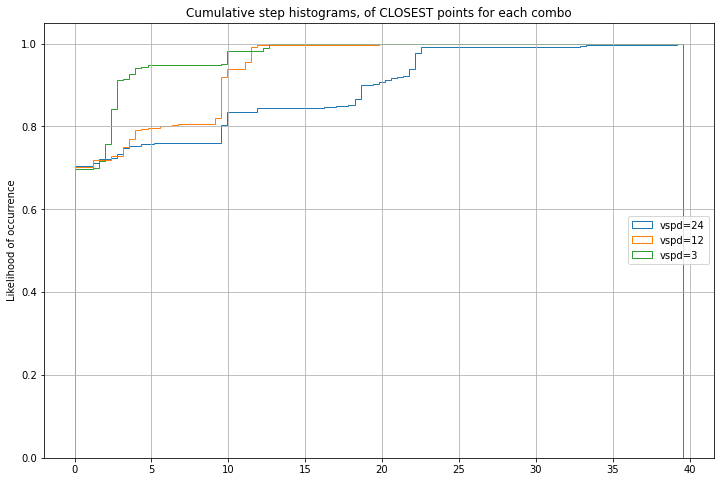

In [86]:
# plotting CDF of the closest points
fig, ax = plt.subplots(figsize=(12, 8))
n_bins = 100

df_diff2 = df_diff[(df_diff['vdir'] == '0') | (df_diff['vdir'] == '2') | (df_diff['detect_clp'] == '6.0')]

# plot the cumulative histogram
n, bins, patches = ax.hist((df_diff2[df_diff2['vspd']=="024"])['spd'], n_bins, density=True, histtype='step',
                           cumulative=True, label='vspd=24')

ax.hist((df_diff2[df_diff2['vspd']=="012"])['spd'], bins=bins, density=True, histtype='step',
                           cumulative=True, label='vspd=12')

ax.hist((df_diff2[df_diff2['vspd']=="003"])['spd'], bins=bins, density=True, histtype='step',
                           cumulative=True, label='vspd=3')
ax.grid(True)
ax.legend(loc='right')
ax.set_title('Cumulative step histograms, of CLOSEST points for each combo')
ax.set_xlabel('')
ax.set_ylabel('Likelihood of occurrence')

plt.show()

In [64]:
# How far away are we from expected?
df_diff = trial_df.copy(deep=True)
df_diff['spd_err'] = df_diff.apply(lambda x: p_err(float(x["vspd"]),x["spd"]), axis=1)
df_diff['vdir_d'] = df_diff.apply(lambda x: trans_dir(int(x["vdir"])), axis=1)
df_diff['dir_err'] = df_diff.apply(lambda x: p_err(x["vdir_d"], x["dir"]), axis=1)

In [69]:
df_diff2 = df_diff[(df_diff['vdir'] == '0') | (df_diff['vdir'] == '2')]

In [70]:
df_diff2

,date,r0,vspd,vdir,sub_len,detect_clp,dir,dir_std,spd,spd_std,count,spd_err,vdir_d,dir_err
0,20180531,0.15,003,0,5.0,2.0,7.597452,100.078867,3.331656,3.637048,1072.0,0.110552,180.0,0.957792
1,20180531,0.15,003,0,5.0,3.0,207.226498,50.768349,2.252667,1.366517,33.0,0.249111,180.0,0.151258
2,20180531,0.15,003,0,5.0,4.0,203.757781,29.245593,1.950900,0.644438,13.0,0.349700,180.0,0.131988
3,20180531,0.15,003,0,5.0,5.0,331.681430,11.196213,12.845476,1.717505,56.0,3.281825,180.0,0.842675
4,20180531,0.15,003,0,5.0,6.0,332.729542,10.289546,12.838539,1.480769,46.0,3.279513,180.0,0.848497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2125,20210429,0.20,024,2,200.0,2.0,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,360.0,1.000000
2126,20210429,0.20,024,2,200.0,3.0,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,360.0,1.000000
2127,20210429,0.20,024,2,200.0,4.0,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,360.0,1.000000
2128,20210429,0.20,024,2,200.0,5.0,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,360.0,1.000000


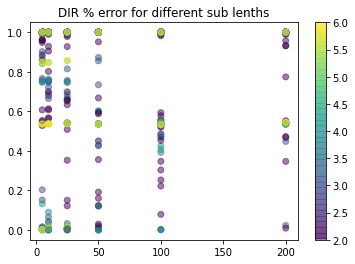

In [71]:
#plotting % difference vs window size
plt.title("DIR % error for different sub lenths")

plt.scatter(df_diff2["sub_len"], df_diff2['dir_err'], c=df_diff2['detect_clp'], alpha= 0.5)
plt.colorbar()
# acter looking at this, it should be a histogram

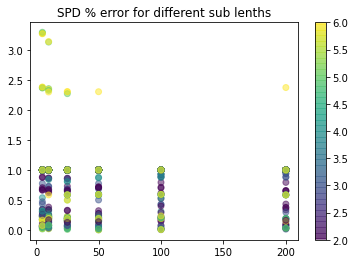

In [72]:
#plotting % difference vs window size
plt.title("SPD % error for different sub lenths")

plt.scatter(df_diff2["sub_len"], df_diff2['spd_err'], c=df_diff2['detect_clp'], alpha= 0.5)
plt.colorbar()
# acter looking at this, it should be a histogram

In [73]:
df_diff2

,date,r0,vspd,vdir,sub_len,detect_clp,dir,dir_std,spd,spd_std,count,spd_err,vdir_d,dir_err
0,20180531,0.15,003,0,5.0,2.0,7.597452,100.078867,3.331656,3.637048,1072.0,0.110552,180.0,0.957792
1,20180531,0.15,003,0,5.0,3.0,207.226498,50.768349,2.252667,1.366517,33.0,0.249111,180.0,0.151258
2,20180531,0.15,003,0,5.0,4.0,203.757781,29.245593,1.950900,0.644438,13.0,0.349700,180.0,0.131988
3,20180531,0.15,003,0,5.0,5.0,331.681430,11.196213,12.845476,1.717505,56.0,3.281825,180.0,0.842675
4,20180531,0.15,003,0,5.0,6.0,332.729542,10.289546,12.838539,1.480769,46.0,3.279513,180.0,0.848497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2125,20210429,0.20,024,2,200.0,2.0,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,360.0,1.000000
2126,20210429,0.20,024,2,200.0,3.0,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,360.0,1.000000
2127,20210429,0.20,024,2,200.0,4.0,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,360.0,1.000000
2128,20210429,0.20,024,2,200.0,5.0,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,360.0,1.000000


[]

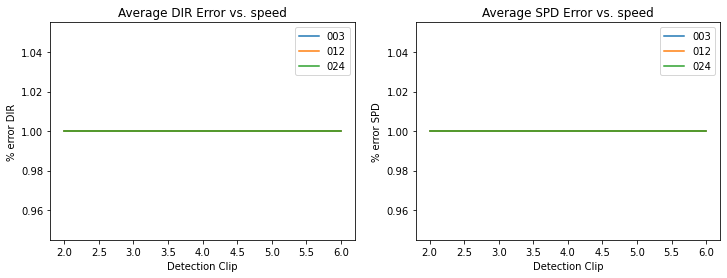

In [83]:
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
for spd_val in df_diff2.vspd.unique():
    df = df_diff2[df_diff2['vspd'] == spd_val]
    clips = df.detect_clp.unique()
    avg_err = [np.mean(df[df['detect_clp']==dc_1]['dir_err']) for dc_1 in clips]
    plt.plot(clips, avg_err, label = spd_val)
plt.legend()
plt.xlabel('Detection Clip')
plt.ylabel('% error DIR') 
plt.title('Average DIR Error vs. speed')

plt.subplot(1, 2, 2)
for spd_val in df_diff2.vspd.unique():
    df = df_diff2[df_diff2['vspd'] == spd_val]
    clips = df.detect_clp.unique()
    avg_err = [np.mean(df[df['detect_clp']==dc_1]['spd_err']) for dc_1 in clips]
    plt.plot(clips, avg_err, label = spd_val)
plt.legend()
plt.xlabel('Detection Clip')
plt.ylabel('% error SPD') 
plt.title('Average SPD Error vs. speed')
plt.plot()

[]

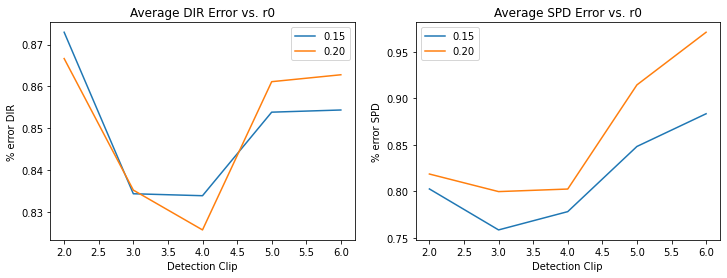

In [75]:
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
for spd_val in df_diff2.r0.unique():
    df = df_diff2[df_diff2['r0'] == spd_val]
    clips = df.detect_clp.unique()
    avg_err = [np.mean(df[df['detect_clp']==dc_1]['dir_err']) for dc_1 in clips]
    plt.plot(clips, avg_err, label = spd_val)
plt.legend()
plt.xlabel('Detection Clip')
plt.ylabel('% error DIR') 
plt.title('Average DIR Error vs. r0')

plt.subplot(1, 2, 2)
for spd_val in df_diff2.r0.unique():
    df = df_diff2[df_diff['r0'] == spd_val]
    clips = df.detect_clp.unique()
    avg_err = [np.mean(df[df['detect_clp']==dc_1]['spd_err']) for dc_1 in clips]
    plt.plot(clips, avg_err, label = spd_val)
plt.legend()
plt.xlabel('Detection Clip')
plt.ylabel('% error SPD') 
plt.title('Average SPD Error vs. r0')
plt.plot()

[]

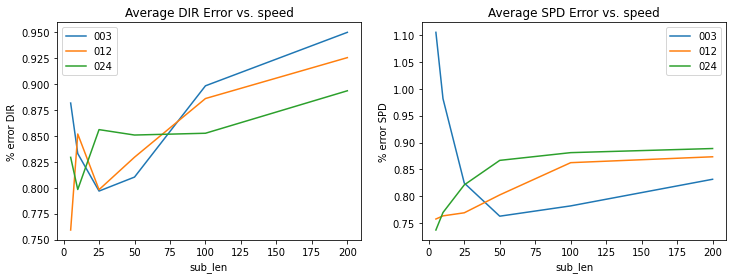

In [81]:
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
for spd_val in df_diff2.vspd.unique():
    df = df_diff2[df_diff2['vspd'] == spd_val]
    clips = df.sub_len.unique()
    avg_err = [np.mean(df[df['sub_len']==dc_1]['dir_err']) for dc_1 in clips]
    plt.plot(clips, avg_err, label = spd_val)
plt.legend()
plt.xlabel('sub_len')
plt.ylabel('% error DIR') 
plt.title('Average DIR Error vs. speed')

plt.subplot(1, 2, 2)
for spd_val in df_diff2.vspd.unique():
    df = df_diff2[df_diff2['vspd'] == spd_val]
    clips = df.sub_len.unique()
    avg_err = [np.mean(df[df['sub_len']==dc_1]['spd_err']) for dc_1 in clips]
    plt.plot(clips, avg_err, label = spd_val)
plt.legend()
plt.xlabel('sub_len')
plt.ylabel('% error SPD') 
plt.title('Average SPD Error vs. speed')
plt.plot()

[]

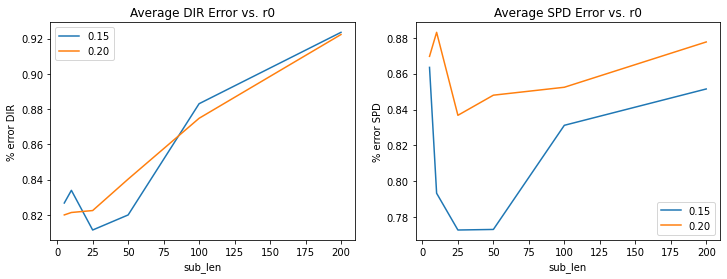

In [82]:
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
for spd_val in df_diff2.r0.unique():
    df = df_diff2[df_diff2['r0'] == spd_val]
    clips = df.sub_len.unique()
    avg_err = [np.mean(df[df['sub_len']==dc_1]['dir_err']) for dc_1 in clips]
    plt.plot(clips, avg_err, label = spd_val)
plt.legend()
plt.xlabel('sub_len')
plt.ylabel('% error DIR') 
plt.title('Average DIR Error vs. r0')

plt.subplot(1, 2, 2)
for spd_val in df_diff2.r0.unique():
    df = df_diff2[df_diff2['r0'] == spd_val]
    clips = df.sub_len.unique()
    avg_err = [np.mean(df[df['sub_len']==dc_1]['spd_err']) for dc_1 in clips]
    plt.plot(clips, avg_err, label = spd_val)
plt.legend()
plt.xlabel('sub_len')
plt.ylabel('% error SPD') 
plt.title('Average SPD Error vs. r0')
plt.plot()

### Looking at inj vdirs

[]

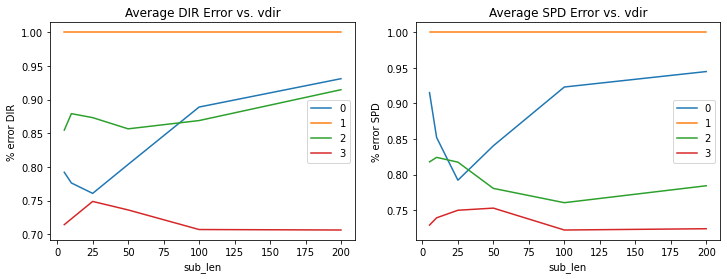

In [80]:
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
for spd_val in df_diff.vdir.unique():
    df = df_diff[df_diff['vdir'] == spd_val]
    clips = df.sub_len.unique()
    avg_err = [np.mean(df[df['sub_len']==dc_1]['dir_err']) for dc_1 in clips]
    plt.plot(clips, avg_err, label = spd_val)
plt.legend()
plt.xlabel('sub_len')
plt.ylabel('% error DIR') 
plt.title('Average DIR Error vs. vdir')

plt.subplot(1, 2, 2)
for spd_val in df_diff.vdir.unique():
    df = df_diff[df_diff['vdir'] == spd_val]
    clips = df.sub_len.unique()
    avg_err = [np.mean(df[df['sub_len']==dc_1]['spd_err']) for dc_1 in clips]
    plt.plot(clips, avg_err, label = spd_val)
plt.legend()
plt.xlabel('sub_len')
plt.ylabel('% error SPD') 
plt.title('Average SPD Error vs. vdir')
plt.plot()

[]

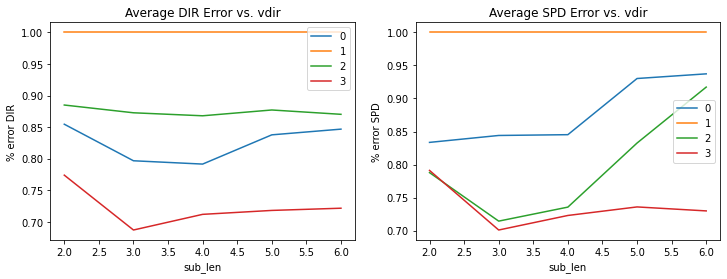

In [78]:
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
for spd_val in df_diff.vdir.unique():
    df = df_diff[df_diff['vdir'] == spd_val]
    clips = df.detect_clp.unique()
    avg_err = [np.mean(df[df['detect_clp']==dc_1]['dir_err']) for dc_1 in clips]
    plt.plot(clips, avg_err, label = spd_val)
plt.legend()
plt.xlabel('sub_len')
plt.ylabel('% error DIR') 
plt.title('Average DIR Error vs. vdir')

plt.subplot(1, 2, 2)
for spd_val in df_diff.vdir.unique():
    df = df_diff[df_diff['vdir'] == spd_val]
    clips = df.detect_clp.unique()
    avg_err = [np.mean(df[df['detect_clp']==dc_1]['spd_err']) for dc_1 in clips]
    plt.plot(clips, avg_err, label = spd_val)
plt.legend()
plt.xlabel('sub_len')
plt.ylabel('% error SPD') 
plt.title('Average SPD Error vs. vdir')
plt.plot()

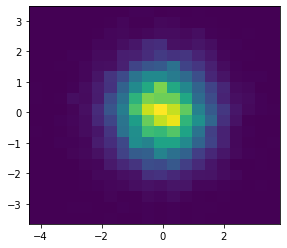

In [164]:
# Plot: grid w_sub vs. d_clip, fixed vspd (3 diff r0) or fixed r0 (multiple speeds)
# - Might need to add another r0
# - Plotting: # with a reasonable detection (did we find a layer in that sp/dir)
# - 1D or 2D distribution?


x = np.random.randn(10000)

y = np.random.randn(10000)


heatmap, xedges, yedges = np.histogram2d(x, y, bins=20)

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]


plt.imshow(heatmap.T, extent=extent, origin='lower')

# Self-injecting layers

In [165]:
## First find files
#ehu:/data/emcewen/sim/2021110[1,2]/simul.YYYYMMDD.aocb.fits files.

sim1 = '/data/emcewen/sim/20211101/simul.20211101_203350.aocb.fits'
sname1 = 'simul.20211101_203350'
sim2 = '/data/emcewen/sim/20211102/simul.20211102_105221.aocb.fits'
sname2 = 'simul.20211102_105221'

## Using this file for testing
# aocb file:
date = '20210827'
aocb = 'aocb0021o'
# test file
file_path = f'{data_path}{date}/ao/{aocb}.fits'
name = f'{date}_{aocb}'

## Correlating Simulation Data

In [166]:
# testing one file
sim_GL = '/data/emcewen/sim/simul_GL/simul.20211120_214434.aocb.fits'
spd = 24
sdir = 2

In [167]:
reload(sCor)
# init object
tmax = 200
curr_data = sCor.SimCorrelator(name, sim_GL, file_path, out_dir, sim_spd = spd, sim_dir= sdir, tmax=tmax, s_sub=True, tt_sub=True)
curr_data.set_trange([0,8150]) # <- length of simulations

# set the range
# curr_data.set_trange([0, 100])
# check that the slopes are the right length:
curr_data.x_slopes.shape

(5, 8150, 8, 8)

In [54]:
# CORRELATING

print("Starting parallel XCor")
t1 = time.time()
curr_data.ccor_gen_par()
t2 = time.time()
print("... Finished in ", str(t2-t1))

Starting parallel XCor
... Finished in  123.88836216926575


In [56]:
curr_data.fits_write()

'/home/emcewen/test_simul/fits/20210827_aocb0021o_tmax200_tts_f0_8150.fits'

In [55]:
curr_data.acor_graph(avg_sub=True, avg_len=200)

'/home/emcewen/test_simul/plots/acor_png/sim20210827_aocb0021o_spd24_dir2_tts_acor_avg_0.png'

## testing the roatation code:

In [168]:
np.average(sim20_corr_data.x_slopes[0], 0).shape

(8, 8)

In [66]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [61]:
## PLOTING: reg sim
wfs = 0
sim_data = Cor.Correlator("simul_GL_24ms", sim_GL, out_dir, tmax=200, s_sub=False, tt_sub=False)
sim_data.set_trange([0, 8150])
sim_data.ccor_gen_par()
data_cx, data_cy = sim_data.data_get_cc_f_all(med_sub=False, avg_sub=True, avg_len=200)
frames1 = (data_cx+data_cy)[0,0] / 2

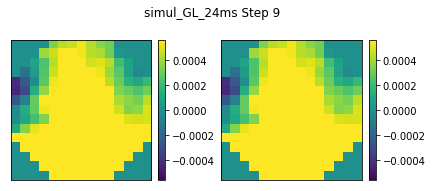

In [69]:
gif_two_cb(frames1, frames1, sim_data.name, f"{sim_data.name}_testsim.gif")

In [72]:
## PLOTING: turned sim 
wfs = 0
sim_dir = 2
sim_data = Cor.Correlator("simul_GL_24ms", sim_GL, out_dir, tmax=200, s_sub=False, tt_sub=False)
sim_data.set_trange([0, 8150])
#rot code
sim_data.x_slopes = np.rot90(sim_data.x_slopes, k=sim_dir, axes=(2, 3))
sim_data.y_slopes = np.rot90(sim_data.y_slopes, k=sim_dir, axes=(2, 3))
sim_data.ccor_gen_par()
#pull correlations
data_cx, data_cy = sim_data.data_get_cc_f_all(med_sub=False, avg_sub=True, avg_len=1000)
frames2 = (data_cx+data_cy)[0,0] / 2

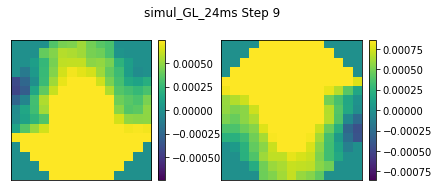

In [75]:
gif_two_cb(frames1, frames2, sim_data.name, f"{sim_data.name}_testsim2.gif")

In [ ]:
# todo, make these plots more readable...

# Pre-injected - paper

- fits files in: `/data/emcewen/sim/injsim`
- structure: `20180531_aocb0069o+injsim.r0_0.10.vspd_001.0.vdir_0.fits`

In [74]:
import pipeline.code.file_reader as fr
reload(fr)

<module 'pipeline.code.file_reader' from '/home/emcewen/code_dev/pipeline/code/file_reader.py'>

In [6]:
inj_dir = "/data/emcewen/sim/injsim/"
inj_fits = fr.fits_pull_dir(inj_dir)

In [60]:
tmax = 1000
file = inj_fits[19]
name = file.replace("/data/emcewen/sim/injsim/", "").replace(".fits", "")
active_wfs = [True, True, True, False, False]
print(name)

20180531_aocb0069o+injsim.r0_0.10.vspd_018.0.vdir_3


In [59]:
curr_data = Cor.Correlator(name, file, out_dir, tmax=tmax, s_sub=True, tt_sub=True)
curr_data.active_wfs = active_wfs
curr_data.n_wfs = sum(active_wfs)
#curr_data.set_trange([0, 8192])

print(f"FILE: {name}")
t0 = time.time()
print("Starting parallel ACor")
curr_data.acor_gen_par()
t1 = time.time()
print("... Finished in ", str(t1-t0))

print("Starting parallel XCor")
curr_data.ccor_gen_par()
t2 = time.time()
print("... Finished in ", str(t2-t1))

print("Writing Fits File")
curr_data.fits_write()
t3 = time.time()
print("... Finished in ", str(t3-t2))
print(curr_data.fits_file)

FILE: 20180531_aocb0069o+injsim.r0_0.10.vspd_018.0.vdir_3
Starting parallel ACor
... Finished in  65.28630471229553
Starting parallel XCor
... Finished in  90.97735095024109
Writing Fits File
... Finished in  0.10868096351623535
/home/emcewen/test_simul/fits/20180531_aocb0069o+injsim.r0_0.10.vspd_018.0.vdir_3_tmax1000_tts.fits


## Plotting

In [37]:
reload(Cor)

<module 'pipeline.code.Correlator' from '/home/emcewen/code_dev/pipeline/code/Correlator.py'>

In [16]:
def plot_all(data, avg_sub=False, sub_len=200):
    g_out = data.acor_graph(t_list=[0,5,10,20,30], avg_sub=avg_sub, avg_len=sub_len)
    print(g_out)
    g_out = data.acor_animate_avg(dt_max=40, avg_sub=avg_sub, avg_len=sub_len)
    print(g_out)
    g_out = data.ccor_graph_all(avg_sub=avg_sub, avg_len=sub_len)
    print(g_out)
    g_out = data.cor_animate_all(dt_max=40, avg_sub=avg_sub, avg_len=sub_len) 
    print(g_out)

In [31]:
p_file = "/home/emcewen/test_simul/fits/20180531_aocb0069o+injsim.r0_0.10.vspd_001.0.vdir_0_tmax200_tts.fits"
curr_data = Cor.Correlator("", "", "", f_file=p_file)
curr_data.active_wfs = active_wfs
curr_data.n_wfs = sum(active_wfs)
# todo: make this part of a saved corr file?

In [56]:
plot_all(curr_data, avg_sub=True)

/home/emcewen/test_simul/plots/acor_png/20180531_aocb0069o+injsim.r0_0.10.vspd_018.0.vdir_3_tts_acor_avg_0.png
/home/emcewen/test_simul/plots/acor_avg_gif/20180531_aocb0069o+injsim.r0_0.10.vspd_018.0.vdir_3_tts_acor_avg_0.gif
/home/emcewen/test_simul/plots/ccor_all_png/20180531_aocb0069o+injsim.r0_0.10.vspd_018.0.vdir_3_tts_ccor_all_0.png
/home/emcewen/test_simul/plots/ccor_all_gif/20180531_aocb0069o+injsim.r0_0.10.vspd_018.0.vdir_3_tts_ccor_all_0.gif


In [26]:
curr_data.n_wfs

4

# Pre rotated - initial 

- FITS files in /data/emcewen/sim/simul_FA/test/
- files are combinations of 20210827/aocb0021o.fits and the simul_FA layer


## Set up from files

In [66]:
# where are the files
aocb_og = "/data/imaka/20210827/ao/aocb0021o.fits"
sim_i_dir = "/data/emcewen/sim/simul_FA/test/"
sim_i_name = ["inject.aocb0021o+20211123_021434.3_0.20.fits", 
              "inject.aocb0021o+20211123_021434.3_0.29.fits"]
p_file = sim_i_dir + sim_i_name[0]

In [69]:
## Adding the simulated data to the structure of an old file
#new aocbs:
sim_a0_name = ["aocb/aocb0021o_sim20.fits", 
               "aocb/aocb0021o_sim29.fits"]

In [70]:
## take data from one, add to the other
i = 1
for i in range(2):
    hl_ao = fits.open("/data/imaka/20210827/ao/aocb0021o.fits") # og aocb
    hl_sim = fits.open(sim_i_dir+sim_i_name[i]) # updates

    hl_ao[3].data = hl_sim[0].data
    hl_ao.writeto(sim_i_dir+sim_a0_name[i])

    hl_ao.close()
    hl_sim.close()

In [74]:
hl_ao = fits.open(sim_i_dir+sim_a0_name[1])
print(hl_ao.info())
hl_ao.close()

Filename: /data/emcewen/sim/simul_FA/test/aocb/aocb0021o_sim29.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      27   (2, 27000)   int32   
  1                1 ImageHDU        83   (1,)   int16 (rescales to uint16)   
  2                1 ImageHDU        26   (1,)   float32   
  3                1 ImageHDU         8   (128, 5, 8192)   float32   
  4                1 ImageHDU         8   (36, 2, 27000)   float32   
  5                1 ImageHDU        20   (96, 96, 5)   int16 (rescales to uint16)   
  6                1 ImageHDU         7   (128, 5)   float32   
  7                1 ImageHDU         7   (36, 1)   float32   
  8                1 ImageHDU        23   (128, 5, 27000)   float32   
None


## Running correlations

In [81]:
## Setup Correlation variables
## out_dir = "/home/emcewen/test_simul/" (from above)
i = 1 # do for both is
name = sim_a0_name[i][5:-5]
file = sim_i_dir+sim_a0_name[i]
tmax = 200

In [82]:
## Start correlations

curr_data = Cor.Correlator(name, file, out_dir, tmax=tmax, s_sub=True, tt_sub=True)
curr_data.set_trange([0, 8192])

print(f"FILE: {name}")
t0 = time.time()
print("Starting parallel ACor")
curr_data.acor_gen_par()
t1 = time.time()
print("... Finished in ", str(t1-t0))

print("Starting parallel XCor")
curr_data.ccor_gen_par()
t2 = time.time()
print("... Finished in ", str(t2-t1))

print("Writing Fits File")
curr_data.fits_write()
t3 = time.time()
print("... Finished in ", str(t3-t2))

FILE: aocb0021o_sim29
Starting parallel ACor
... Finished in  25.496672868728638
Starting parallel XCor
... Finished in  89.01687359809875
Writing Fits File
... Finished in  0.09489321708679199


In [192]:
# findidng and opening correlation files
aocb_cor_f = "/data/emcewen/out/20210827/fits/20210827_aocb0021o_tmax1000_tts.fits"
sim20_cor_f = out_dir + "fits/aocb0021o_sim20_tmax200_tts_f0_8192.fits"
sim29_cor_f = out_dir + "fits/aocb0021o_sim29_tmax200_tts_f0_8192.fits"

In [84]:
# grab the correlator
aocb_corr_data = Cor.Correlator("", "", "", f_file=aocb_cor_f)
sim20_corr_data = Cor.Correlator("", "", "", f_file=sim20_cor_f)
sim29_corr_data = Cor.Correlator("", "", "", f_file=sim29_cor_f)

In [102]:
# grab a matrix stack
corr_objs = [aocb_corr_data, sim20_corr_data, sim29_corr_data]
mats = []

for corr in corr_objs:
    data_cx, data_cy = corr.data_get_cc_f_all(med_sub=False, avg_sub=True, avg_len=200)
    frames1 = (data_cx+data_cy)[2,2] / 2
    mats.append(frames1)

In [103]:
mats[2].shape

(200, 15, 15)

<module 'matplotlib.pyplot' from '/home/emcewen/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

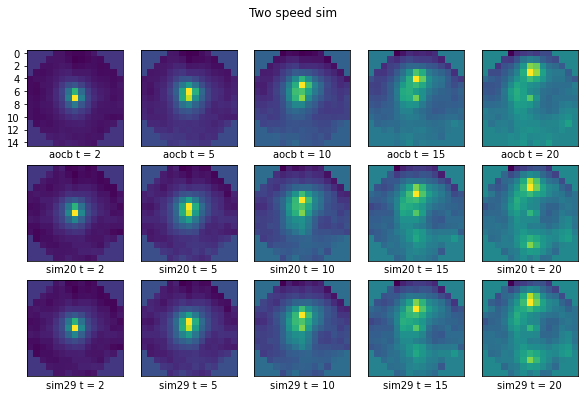

In [104]:
## Plotting pre-simulated layers

t_list = [2, 5, 10, 15,20]
l1 = "aocb"
l2 = "sim20"
l3 = "sim29"
title = "Two speed sim"

graph_3_rows_t_mat(mats[0][:200], mats[1], mats[2], t_list, 
                   title = title, label_1=l1, label_2=l2, label_3=l3)

<module 'matplotlib.pyplot' from '/home/emcewen/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

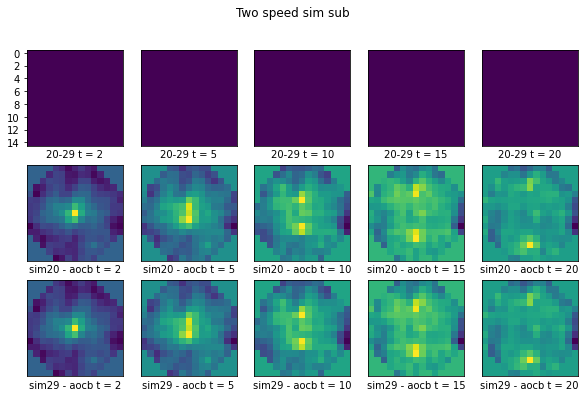

In [65]:
title = "Two speed sim sub"
l1 = "20-29"
l2 = "sim20 - aocb"
l3 = "sim29 - aocb"
graph_3_rows_t_mat(mats[2][:200]-mats[1][:200], mats[1][:200]-mats[0][:200], mats[2][:200]-mats[0][:200], t_list, 
                   title = title, label_1=l1, label_2=l2, label_3=l3)

## Running Estimator

In [128]:
# Generating a calling mechanism based on the injection variables
out_dir = "/home/emcewen/out/injsim/" 
dates = ["20180531", "20180601", "20181219", "20181221", "20181222", "20181223", "20210429", "20210430", "20210501", "20210502"]
files = ["0069", "0072", "0127", "0323", "0133", "0181", "0013", "0023", "0025", "0076"]

r0s = ["0.10", "0.15", "0.20", "0.25", "0.30" ]
vspds = ["001", "003", "006", "012", "018", "024", "036"]
vdirs = ["0", "1", "2", "3"]

fmt = "{out_dir}fits/{date}_aocb{file}o+injsim.r0_{r0}.vspd_{vspd}.0.vdir_{vdir}_tmax1000_tts.fits"
#cor_file = fmt.format(out_dir=out_dir, date=dates[i], file=files[i], r0=r0s[j], vspd=vspds[k], vdir=vdirs[m]) 
fmt_name = "{date}_aocb{file}o+injsim.r0_{r0}.vspd_{vspd}.0.vdir_{vdir}"

In [124]:
reload(er)

<module 'pipeline.code.Estimator_R' from '/home/emcewen/code_dev/pipeline/code/Estimator_R.py'>

In [126]:
import time
j = 0 # strong r0?
k = 3 #speed = 12 ms

df_test = pd.DataFrame()

for i in range(2):
    for m in range(4):
        t0 = time.time()
        print(f"Vars: file{i}, dir {m}")
        cor_file = fmt.format(out_dir=out_dir, date=dates[i], file=files[i], r0=r0s[j], vspd=vspds[k], vdir=vdirs[m]) 
        print(f"file: {cor_file}")
        
        er_pipe = er.Estimate_simple(cor_file)
        er_pipe.update_wfs([True, True, True, False, False])
        er_pipe.update_data_params(est_len = 250, bg_sub = True)

        table_tmp = er_pipe.return_table(sdv_cnd = 2, n_filter = 10)
        n = table_tmp.shape[0]
        table_tmp = table_tmp.assign(date=[dates[i]]*n, r0=[r0s[j]]*n, vspd=[vspds[k]]*n, vdir=[vdirs[m]]*n)
        table_tmp = table_tmp.assign(est_len=[er_pipe.est_len]*n, bg_sub=[er_pipe.bg_sub]*n, sub_len=[er_pipe.sub_len]*n)
                                     
        #add this table to a list of tables                             
        df_test = pd.concat([df_test, table_tmp])
        t1 = time.time()
        print("== finished in %s s"% str(t1-t0))

Vars: file0, dir 0
file: /home/emcewen/out/injsim/fits/20180531_aocb0069o+injsim.r0_0.10.vspd_012.0.vdir_0_tmax1000_tts.fits
== finished in 88.95449209213257 s
Vars: file0, dir 1
file: /home/emcewen/out/injsim/fits/20180531_aocb0069o+injsim.r0_0.10.vspd_012.0.vdir_1_tmax1000_tts.fits
== finished in 87.50422644615173 s
Vars: file0, dir 2
file: /home/emcewen/out/injsim/fits/20180531_aocb0069o+injsim.r0_0.10.vspd_012.0.vdir_2_tmax1000_tts.fits
== finished in 93.64390206336975 s
Vars: file0, dir 3
file: /home/emcewen/out/injsim/fits/20180531_aocb0069o+injsim.r0_0.10.vspd_012.0.vdir_3_tmax1000_tts.fits
== finished in 87.89357948303223 s
Vars: file1, dir 0
file: /home/emcewen/out/injsim/fits/20180601_aocb0072o+injsim.r0_0.10.vspd_012.0.vdir_0_tmax1000_tts.fits
== finished in 91.65559267997742 s
Vars: file1, dir 1
file: /home/emcewen/out/injsim/fits/20180601_aocb0072o+injsim.r0_0.10.vspd_012.0.vdir_1_tmax1000_tts.fits
== finished in 99.2624397277832 s
Vars: file1, dir 2
file: /home/emcewen/ou

In [127]:
df_test

,dir,dir_std,spd,spd_std,count,class,xcor,name,clstr_method,detect_clp,sdv_comp,sdv_cnd,n_filter,date,r0,vspd,vdir,est_len,bg_sub,sub_len
0,162.932264,5.220825,1.018223,0.091693,113.0,FL,0,20180531_aocb0069o+injsim.r0_0.10.vspd_012.0.v...,meanshift,4,3,2,10,20180531,0.10,012,0,250,True,200
1,180.000000,0.000000,9.647161,0.754823,21.0,FL,0,20180531_aocb0069o+injsim.r0_0.10.vspd_012.0.v...,meanshift,4,3,2,10,20180531,0.10,012,0,250,True,200
2,108.434949,0.000000,1.651488,0.110903,19.0,FL,0,20180531_aocb0069o+injsim.r0_0.10.vspd_012.0.v...,meanshift,4,3,2,10,20180531,0.10,012,0,250,True,200
3,56.309932,0.000000,0.482972,0.037476,63.0,NA,1,20180531_aocb0069o+injsim.r0_0.10.vspd_012.0.v...,meanshift,4,3,2,10,20180531,0.10,012,0,250,True,200
4,63.434949,0.000000,0.568840,0.032599,46.0,NA,1,20180531_aocb0069o+injsim.r0_0.10.vspd_012.0.v...,meanshift,4,3,2,10,20180531,0.10,012,0,250,True,200
5,45.000000,0.000000,0.462425,0.032012,18.0,NA,1,20180531_aocb0069o+injsim.r0_0.10.vspd_012.0.v...,meanshift,4,3,2,10,20180531,0.10,012,0,250,True,200
6,75.963757,0.000000,0.477039,0.003719,10.0,NA,1,20180531_aocb0069o+injsim.r0_0.10.vspd_012.0.v...,meanshift,4,3,2,10,20180531,0.10,012,0,250,True,200
0,159.562126,3.533332,0.986469,0.058542,46.0,FL,0,20180531_aocb0069o+injsim.r0_0.10.vspd_012.0.v...,meanshift,4,3,2,10,20180531,0.10,012,1,250,True,200
1,90.000000,0.000000,9.840441,0.467434,16.0,FL,0,20180531_aocb0069o+injsim.r0_0.10.vspd_012.0.v...,meanshift,4,3,2,10,20180531,0.10,012,1,250,True,200
2,56.309932,0.000000,0.486943,0.031640,71.0,NA,1,20180531_aocb0069o+injsim.r0_0.10.vspd_012.0.v...,meanshift,4,3,2,10,20180531,0.10,012,1,250,True,200


In [121]:
df_test_no_sub

,dir,dir_std,spd,spd_std,count,class,xcor,name,clstr_method,detect_clp,sdv_comp,sdv_cnd,n_filter,r0,vspd,vdir
0,63.434949,0.000000,0.565778,0.053409,101.0,GL,0,20180531_aocb0069o+injsim.r0_0.10.vspd_012.0.v...,meanshift,4,3,2,10,0.10,012,0
1,56.309932,0.000000,0.463109,0.042985,100.0,GL,0,20180531_aocb0069o+injsim.r0_0.10.vspd_012.0.v...,meanshift,4,3,2,10,0.10,012,0
2,45.000000,0.000000,0.522889,0.042476,76.0,GL,0,20180531_aocb0069o+injsim.r0_0.10.vspd_012.0.v...,meanshift,4,3,2,10,0.10,012,0
3,75.963757,0.000000,0.504282,0.011338,16.0,GL,0,20180531_aocb0069o+injsim.r0_0.10.vspd_012.0.v...,meanshift,4,3,2,10,0.10,012,0
4,56.309932,0.000000,0.482972,0.037476,63.0,GL,1,20180531_aocb0069o+injsim.r0_0.10.vspd_012.0.v...,meanshift,4,3,2,10,0.10,012,0
5,63.434949,0.000000,0.568840,0.032599,46.0,GL,1,20180531_aocb0069o+injsim.r0_0.10.vspd_012.0.v...,meanshift,4,3,2,10,0.10,012,0
6,45.000000,0.000000,0.462425,0.032012,18.0,GL,1,20180531_aocb0069o+injsim.r0_0.10.vspd_012.0.v...,meanshift,4,3,2,10,0.10,012,0
7,75.963757,0.000000,0.477039,0.003719,10.0,GL,1,20180531_aocb0069o+injsim.r0_0.10.vspd_012.0.v...,meanshift,4,3,2,10,0.10,012,0
0,57.387102,6.531551,0.532092,0.059992,167.0,GL,0,20180531_aocb0069o+injsim.r0_0.10.vspd_012.0.v...,meanshift,4,3,2,10,0.10,012,1
1,75.963757,0.000000,0.531283,0.023865,31.0,GL,0,20180531_aocb0069o+injsim.r0_0.10.vspd_012.0.v...,meanshift,4,3,2,10,0.10,012,1


In [134]:
dftmp = df_test[df_test['name']=="20180531_aocb0069o+injsim.r0_0.10.vspd_012.0.vdir_0"]

In [137]:
dftmp[dftmp["spd"] > 8.4 && dftmp["spd"] < 15.6]

SyntaxError: invalid syntax (<ipython-input-137-274eae612f63>, line 1)

In [169]:
found = []
going_dir = []

df = df_test_no_sub

for m in range(4):
    count = 0
    for i in range(2):
        cor_name = fmt_name.format(date=dates[i], file=files[i], r0=r0s[j], vspd=vspds[k], vdir=vdirs[m]) 
        df = df[df['name']==cor_name]
        
        if len(df_tmp[(df_tmp["spd"] > 8.4) & (df_tmp["spd"] < 15.6)]) > 0:
            count = count + 1
        else:
            print(df_tmp["spd"])
    found.append(count)
    going_dir.append(df_tmp["vdir"][0])

In [171]:
found

[2, 2, 2, 2]

In [168]:
found1 = found
going_Dir = going_dir

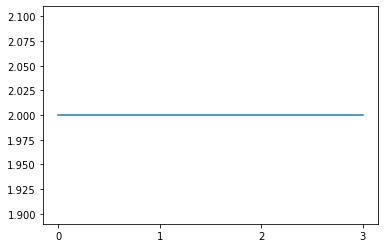

In [170]:
plt.plot(going_Dir, found1)
plt.plot(going_dir, found)

In [120]:
df_test_no_sub = df_test

In [85]:
reload(er)

<module 'pipeline.code.Estimator_R' from '/home/emcewen/code_dev/pipeline/code/Estimator_R.py'>

In [180]:
# estimator steps
out_dir = "/home/emcewen/out/injsim/" 
sim20_cor_f = out_dir + "fits/20180531_aocb0069o+injsim.r0_0.20.vspd_012.0.vdir_0_tmax1000_tts.fits"

# set up object
er_pipe = er.Estimate_simple(sim20_cor_f)
er_pipe.update_wfs([True, True, True, False, False])
er_pipe.update_data_params(est_len = 250, bg_sub = True)

In [184]:
# run estimation and return table
table = er_pipe.return_table(sdv_cnd = 2, n_filter = 5)

In [185]:
table

,dir,dir_std,spd,spd_std,count,class,xcor,name,clstr_method,detect_clp,sdv_comp,sdv_cnd,n_filter
0,158.198591,0.000000,1.040442,0.078694,57.0,FL,0,20180531_aocb0069o+injsim.r0_0.20.vspd_012.0.v...,meanshift,4,3,2,5
1,168.690068,0.000000,0.980975,0.071865,55.0,FL,0,20180531_aocb0069o+injsim.r0_0.20.vspd_012.0.v...,meanshift,4,3,2,5
2,108.434949,0.000000,1.631408,0.099221,17.0,FL,0,20180531_aocb0069o+injsim.r0_0.20.vspd_012.0.v...,meanshift,4,3,2,5
3,59.527241,3.545787,0.517839,0.061038,155.0,NA,1,20180531_aocb0069o+injsim.r0_0.20.vspd_012.0.v...,meanshift,4,3,2,5
4,45.000000,0.000000,0.496045,0.052311,64.0,NA,1,20180531_aocb0069o+injsim.r0_0.20.vspd_012.0.v...,meanshift,4,3,2,5
5,75.963757,0.000000,0.499860,0.022103,34.0,NA,1,20180531_aocb0069o+injsim.r0_0.20.vspd_012.0.v...,meanshift,4,3,2,5


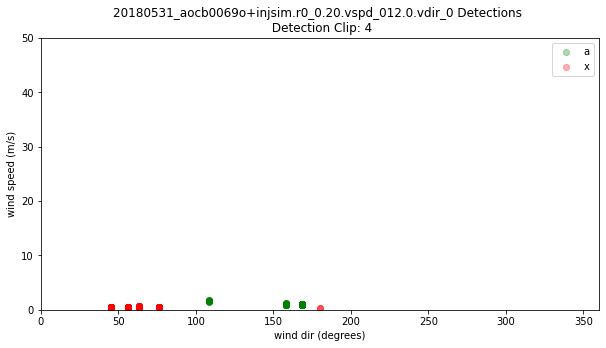

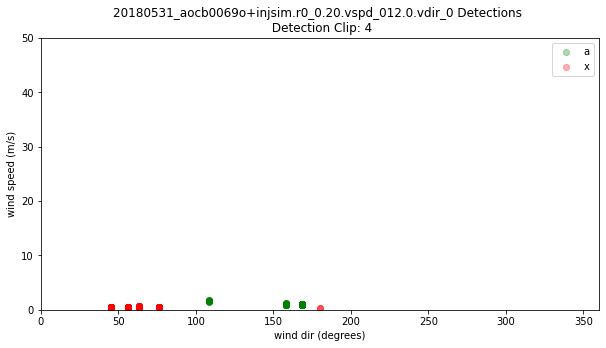

In [183]:
er_pipe.plot_spds_detect()

In [88]:
m = er_pipe.x_d_lvl

m[m > er_pipe.detect_clp] = 1
m[m != 1 ] = 0

In [91]:
gif_two_cb(mats[1][:200], m, "cross detects", "test_x_detects.gif")

NameError: name 'mats' is not defined

In [127]:
# Run estimation with plotting (saved to out_dir)
er.est_file(sim20_cor_f, plot = True)

/home/emcewen/test_simul/est/cor_prob/aocb0021o_sim20_stt_cor_prob_2.png


,dir,dir_std,spd,spd_std,count,class,xcor,name,clstr_method,detect_clp,sdv_comp,sdv_cnd,n_filter
0,135.0,63.94442,2.051738,0.269287,27.0,GL,0,aocb0021o_sim20,meanshift,4,3,2,20
1,315.0,0.00000,2.541096,0.481100,49.0,GL,1,aocb0021o_sim20,meanshift,4,3,2,20


In [ ]:
# Take old aocb, swap out data, then correlate
# need to make a copy of the fits file?

# Appendix

### Quick look at STDV maps

In [188]:
rad_map = np.array([[np.sqrt(i**2 + j**2) for j in np.arange(-7, 8)] for i in np.arange(-7, 8)])
rad_map_boolean = np.zeros((8, 15, 15))
# boolean mask matrix
for i in np.arange(0, 8):
    rad_max = ma.masked_where(rad_map <=  i + 0.5, rad_map)
    rad_min = ma.masked_where(rad_map >  i - 0.5, rad_map)
    rad = rad_max.mask & rad_min.mask
    rad_map_boolean[i-1] = rad
rad_map_inv = np.ones(rad_map_boolean.shape) - rad_map_boolean

def stdv_map(avg_wf):
    #detect_lvl = np.zeros_like(avg_wfs)
    t_mean = np.zeros_like(avg_wf)
    t_stdev = np.zeros_like(avg_wf)
    
    list_stdev = []

    for t in range(avg_wf.shape[0]):
        # 1.1.  For each pixel in the cov map assign a radius
        t_slice = avg_wf[t]
        sigma = 3
        # 1.2. find the mean (m) and stddev (sd) of the pixels 
        # in a radial annuli one pixel wide (r from 1 to 7 +/- 0.5.  
        # I do a sigma clipping on this with a clip=3 si
        t_stdv = []
        for r in np.arange(8):
            rad_vals = np.multiply(t_slice, rad_map_boolean[r])
            mean, median, std = sigma_clipped_stats(rad_vals, sigma=sigma, mask=rad_map_inv[r])
            t_stdv.append(std)
        list_stdev.append(t_stdv)
    # 1.3. For each pixel I assign a "detection level in sigma over the mean"
    # = (im[x,y] - m)/sd.   
    # This results in a detection map for each cov map time slice. 
    #detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
    return list_stdev

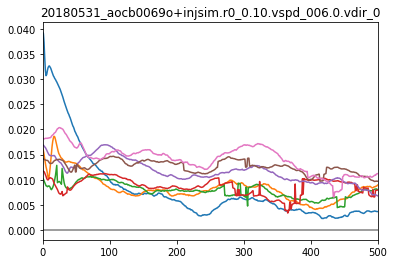

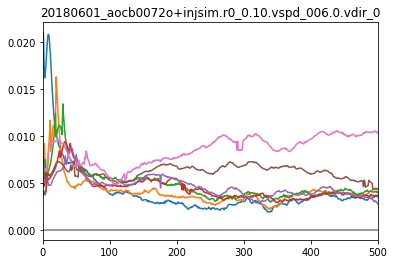

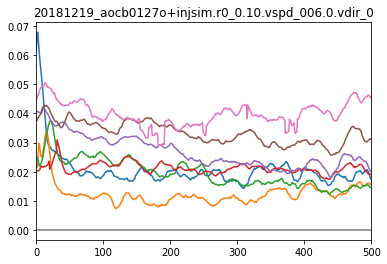

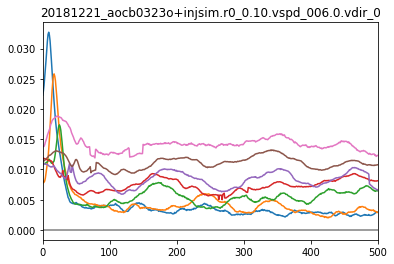

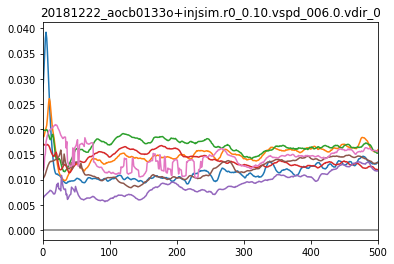

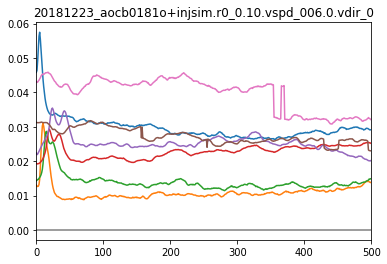

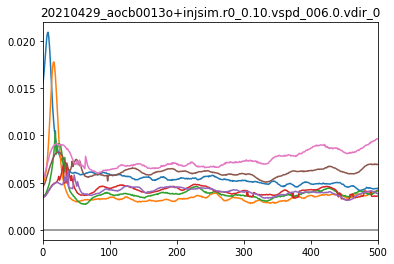

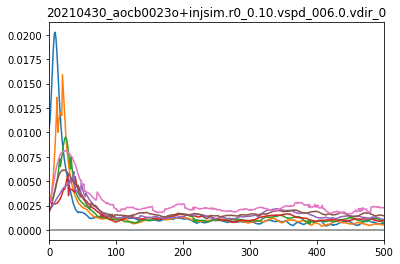

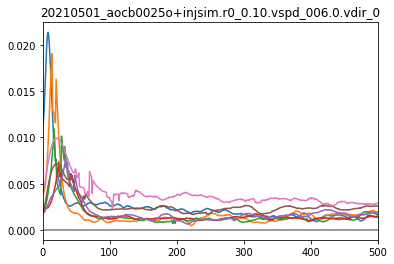

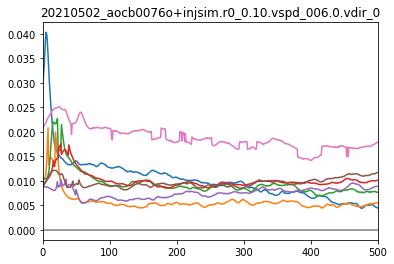

In [191]:
j = 0 # strong r0?
k = 2 #speed = 6 ms
m = 0

for i in range(len(dates)):
    cor_file = fmt.format(out_dir=out_dir, date=dates[i], file=files[i], r0=r0s[j], vspd=vspds[k], vdir=vdirs[m])
    curr_data = Cor.Correlator("", "", "", f_file=cor_file)
    avg_acor = curr_data.avg_acor(avg_sub = False, avg_len = 0, mov_sub=False, sig_clip=False)
    stdv_mp = stdv_map(avg_acor)
    
    plt.plot(stdv_mp)
    plt.xlim(0,500)
    plt.title(curr_data.name)
    plt.show()

## Two by two plotting

In [90]:
# PLOT: background and correlation side by side
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable

def gif_two_cb(data1, data2, title, out_file):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
    plt.setp(axes, xticks=[], yticks=[]) # turn off tick marks

    div1 = make_axes_locatable(axes[0])
    cax1 = div1.append_axes('right', '5%', '5%')
    div2 = make_axes_locatable(axes[-1])
    cax2 = div2.append_axes('right', '5%', '5%')

    # This is now a list of arrays rather than a list of artists
    d1_0 = data1[0]
    d2_0 = data2[0]

    im1 = axes[0].imshow(d1_0, origin='lower') # Here make an AxesImage rather than contour
    im2 = axes[1].imshow(d2_0, origin='lower')
    cb1 = fig.colorbar(im1, cax=cax1)
    cb2 = fig.colorbar(im2, cax=cax2)
    tx = fig.suptitle(f'{title} Step 0')

    #vstd1 = 4*np.median(np.std(data1, axis=(1,2)))
    vstd1 = np.max(data1)
    #vstd2 = 4*np.median(np.std(data2, axis=(1,2)))
    vstd2 = np.max(data2)
    fig.tight_layout()

    def animate(i):
        vstd1 = np.max(data1[i])
        im1.set_data(data1[i])
        im1.set_clim(-vstd1, +vstd1)
        im2.set_data(data2[i])
        im2.set_clim(-vstd2, +vstd2)
        tx.set_text(f'{title} Step {i}')

    ani = animation.FuncAnimation(fig, animate, frames=30)
    ani.save(out_file, writer = 'imagemagick')

## testing multiprocessing

In [193]:
# findidng and opening correlation files
aocb_cor_f = "/data/emcewen/out/20210827/fits/20210827_aocb0021o_tmax1000_tts.fits"
sim20_cor_f = out_dir + "fits/aocb0021o_sim20_tmax200_tts_f0_8192.fits"
sim29_cor_f = out_dir + "fits/aocb0021o_sim29_tmax200_tts_f0_8192.fits"
img_files = [aocb_cor_f, sim20_cor_f, sim29_cor_f]
N_files = 3

In [198]:
import multiprocessing as mp

cpu_count = 3
# Start the pool
pool = mp.Pool(cpu_count)
results_async = []
print(f'Estimation in parallel with {cpu_count} cores.')



for ii in range(N_files):
    img_file = img_files[ii]

    #####
    # Add calc for this starlist to the pool.
    #####
    results = pool.apply_async(single_est, (img_file, img_file))
    results_async.append(results)

pool.close()
pool.join()


File: /home/emcewen/out/injsim/fits/aocb0021o_sim20_tmax200_tts_f0_8192.fitsFile: /data/emcewen/out/20210827/fits/20210827_aocb0021o_tmax1000_tts.fitsFile: /home/emcewen/out/injsim/fits/aocb0021o_sim29_tmax200_tts_f0_8192.fits




fit_moffat in parallel with 3 cores.
== finished in 133.58776354789734 s


In [215]:
word = "hello"
word[:2]

'he'

In [ ]:
import itertools

date_idxs = [0, 4, 6] # pre-selected
r0s_idxs = [1,2]
vspd_idxs = [1,3,5]

itertools.product(date_idxs, r0s_idxs, vspd_idxs)

In [204]:
df_sum = pd.DataFrame()

for ii in range(N_files):
    try:
        results = results_async[ii].get()
        print(results)
        df_sum = pd.concat([df_sum, results])
    except:
        print("error with file: ", img_files[ii])

          dir   dir_std        spd   spd_std  count class  xcor  \
0   88.557908   7.30425   8.519543  1.132089   70.0    FL     0   
1  248.975439  30.60659   1.558822  0.445965   12.0    GL     0   
2  180.000000   0.00000  10.136226  6.101518   32.0    GL     1   

                 name clstr_method  detect_clp  sdv_comp  sdv_cnd  n_filter  \
0  20210827_aocb0021o    meanshift           4         3        2        10   
1  20210827_aocb0021o    meanshift           4         3        2        10   
2  20210827_aocb0021o    meanshift           4         3        2        10   

       date    r0 vspd vdir  est_len  bg_sub  sub_len  
0  20210502  0.10  006    0      250    True      200  
1  20210502  0.10  006    0      250    True      200  
2  20210502  0.10  006    0      250    True      200  
error with file:  /home/emcewen/out/injsim/fits/aocb0021o_sim20_tmax200_tts_f0_8192.fits
error with file:  /home/emcewen/out/injsim/fits/aocb0021o_sim29_tmax200_tts_f0_8192.fits


In [205]:
df_sum

,dir,dir_std,spd,spd_std,count,class,xcor,name,clstr_method,detect_clp,sdv_comp,sdv_cnd,n_filter,date,r0,vspd,vdir,est_len,bg_sub,sub_len
0,88.557908,7.30425,8.519543,1.132089,70.0,FL,0,20210827_aocb0021o,meanshift,4,3,2,10,20210502,0.10,006,0,250,True,200
1,248.975439,30.60659,1.558822,0.445965,12.0,GL,0,20210827_aocb0021o,meanshift,4,3,2,10,20210502,0.10,006,0,250,True,200
2,180.000000,0.00000,10.136226,6.101518,32.0,GL,1,20210827_aocb0021o,meanshift,4,3,2,10,20210502,0.10,006,0,250,True,200


In [194]:
def single_est(cor_file, name, **kwargs):
    """
    Takes in a file and various kwargs
    """
    df_test = pd.DataFrame()
    
    t0 = time.time()
    print(f"File: {name}")
    er_pipe = er.Estimate_simple(cor_file)
    er_pipe.update_wfs([True, True, True, False, False])
    er_pipe.update_params(**kwargs)
    er_pipe.update_data_params(est_len = 250, bg_sub = True, **kwargs)
    
    # Estimatior call 
    table_tmp = er_pipe.return_table(sdv_cnd = 2, n_filter = 10)
    
    #add this table to a list of tables 
    n = table_tmp.shape[0]
    table_tmp = table_tmp.assign(date=[dates[i]]*n, r0=[r0s[j]]*n, vspd=[vspds[k]]*n, vdir=[vdirs[m]]*n)
    table_tmp = table_tmp.assign(est_len=[er_pipe.est_len]*n, bg_sub=[er_pipe.bg_sub]*n, sub_len=[er_pipe.sub_len]*n)       
    df_test = pd.concat([df_test, table_tmp])
    
    t1 = time.time()
    print("== finished in %s s"% str(t1-t0))
    return df_test

In [210]:
import itertools

date_idxs = [0, 4, 6] # pre-selected
r0s_idxs = [1,2]
vspd_idxs = [1,3,5]

file_idxs = list(itertools.product(date_idxs, r0s_idxs, vspd_idxs))

In [211]:
cor_files = [i+j+k for i,j,k in file_idxs]

In [212]:
cor_files

[2, 4, 6, 3, 5, 7, 6, 8, 10, 7, 9, 11, 8, 10, 12, 9, 11, 13]

In [214]:
file_idxs[0][1]

1

In [216]:
import test_sim as tes_s

In [217]:
tes_s.single_est(aocb_cor_f, "test", sub_len=200, detect_clp=4, 
                            bg_sub=True, move_sub=True, est_len=250)

,dir,dir_std,spd,spd_std,count,class,xcor,name,clstr_method,detect_clp,sdv_comp,sdv_cnd,n_filter,est_len,bg_sub,sub_len
0,87.837696,7.082811,8.357501,1.513196,75.0,FL,0,20210827_aocb0021o,meanshift,4,3,2,10,250,True,200
1,253.412373,28.875184,1.458896,0.524486,10.0,GL,0,20210827_aocb0021o,meanshift,4,3,2,10,250,True,200
2,180.000000,0.000000,10.136226,6.101518,32.0,GL,1,20210827_aocb0021o,meanshift,4,3,2,10,250,True,200


In [218]:
wind_sub = [5, 10, 25, 50, 100, 200]
d_clip = [2,3,4,5,6]
est_params = file_idxs = list(itertools.product(wind_sub, d_clip))

for w, d, in est_params:
    print(w,d)

5 2
5 3
5 4
5 5
5 6
10 2
10 3
10 4
10 5
10 6
25 2
25 3
25 4
25 5
25 6
50 2
50 3
50 4
50 5
50 6
100 2
100 3
100 4
100 5
100 6
200 2
200 3
200 4
200 5
200 6
